In [35]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
import glob
import imageio



In [36]:
"""from perception import color_thresh
from perception import rover_coords
from perception import to_polar_coords
from perception import perspect_transform"""

'from perception import color_thresh\nfrom perception import rover_coords\nfrom perception import to_polar_coords\nfrom perception import perspect_transform'

../test_dataset/IMG/robocam_2017_05_02_11_16_27_547.jpg


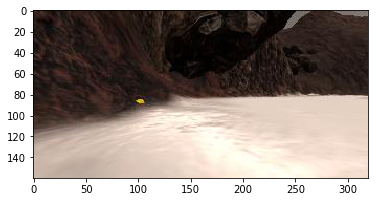

In [37]:
#Example image
path = "../test_dataset/IMG/*" 
img_list = glob.glob(path) #return list of img pathnames


#Grab a random image and display it
i = np.random.randint(0, len(img_list) - 1)
print(img_list[i])
image = mpimg.imread(img_list[i]) #RGB

plt.imshow(image)

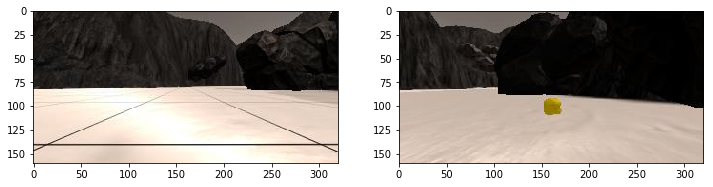

In [38]:
# Calibration
# Using grid image to get coordinates to warp perspective. 
# We use the perspective mask later to get the bird eye view of the world map

example_grid = "../calibration_images/example_grid1.jpg"
example_rock ="../calibration_images/example_rock1.jpg"

grid_image = mpimg.imread(example_grid)
rock_image = mpimg.imread(example_rock)

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_image)
plt.subplot(122)
plt.imshow(rock_image)

In [39]:
# Perspect Transform

def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    mask = cv2.warpPerspective(np.ones_like(img[:,:,0]),M,(img.shape[1],img.shape[0]))
    return warped, mask

In [40]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:, 0] > rgb_thresh[0]) \
                  &(img[:,:, 1] > rgb_thresh[1]) \
                  &(img[:,:, 2] > rgb_thresh[2])
    
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

In [41]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
    ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot) + xpos
    ypix_translated = (ypix_rot) + ypos
    # Return the result 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

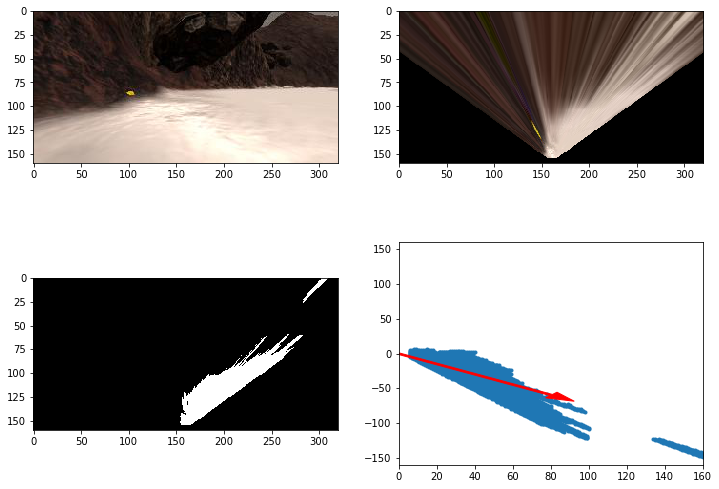

In [42]:
dst = 5
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])

destination = np.float32([[image.shape[1] / 2 - dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - bottom_offset],
                          [image.shape[1] / 2 + dst, image.shape[0] - 2*dst - bottom_offset],
                          [image.shape[1] / 2 - dst, image.shape[0] - 2*dst - bottom_offset]])


image = mpimg.imread(img_list[i])
warped, mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)


In [43]:
#% run drive_rover.py

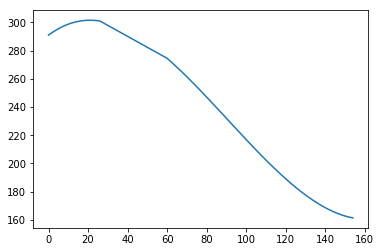

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
import glob
import imageio
import decision
    
new_nav_angles =[]
ones = np.argwhere(threshed==1)

x = [i[0] for i in ones]
y = [i[1] for i in ones]

coeff = np.polyfit(x, y, deg=3) 
yvals = np.polyval(coeff, x) #get y vals from x vals
for i in x:
   new_nav_angles=(np.arctan2(np.polyval(coeff, i),i)) #angles for rover path

plt.plot(x,yvals)
